In [1]:
import fimdp
import fimdpenv
import fimdpenv.UUVEnv as UUVEnv
fimdpenv.setup()
from fimdp import io as fi2st
from fimdp.objectives import AS_REACH, BUCHI
from fimdp.energy_solvers import BasicES

import stormpy

import pandas as pd

In [2]:
def buchi_storm(storm_mdp):
    formula = 'Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]'
    prop = stormpy.parse_properties(formula)
    
    return stormpy.model_checking(storm_mdp, prop[0])

In [3]:
def buchi_fimdp(mdp, capacity, targets):
    solver = BasicES(mdp, capacity, targets)
    fimdp_res = solver.compute(BUCHI)

In [10]:
def create_gw(size, capacity):

    constants = {
        "size_x" : size,
        "size_y" : size,
        "capacity" : capacity,
        "cons_w_ex" : 0,
        "cons_s_ex" : 0,
        "targets" : [13,2],
        "reloads" : [15,3],
    }

    env = UUVEnv.SingleAgentEnv([constants["size_x"], constants["size_y"]], constants["capacity"], constants["targets"], constants["reloads"])
    return env.consmdp, set(constants["targets"])

In [5]:
def benchmark_on_gw(size_range, cap_range):
    df = pd.DataFrame(columns=["size", "capacity", "cmdp_size", "mdp_size", "fimdp_time", "storm_time"])

    for size in size_range:
        for capacity in cap_range:
            cap = int(capacity*size)
            print(f"size={size} and capacity={cap}")
            res = {
                "size": size,
                "capacity": cap,
            }

            mdp, targets = create_gw(size, cap)
            res["cmdp_size"] = mdp.num_states

            st_mdp = fi2st.encode_to_stormpy(mdp, cap, targets)
            res["mdp_size"] = st_mdp.nr_states

            fimdp_time = %timeit -o -q buchi_fimdp(mdp, cap, targets)
            res["fimdp_time"] = fimdp_time.average
            storm_time = %timeit -o -q buchi_storm(st_mdp)
            res["storm_time"] = storm_time.average

            df = df.append(res, ignore_index=True)
    return df

In [6]:
results = {}

In [15]:
results = {}
results["test"] = benchmark_on_gw([4], [1, 2])

size=4 and capacity=4
size=4 and capacity=8


In [23]:
df = results["test"]
df

,size,capacity,cmdp_size,mdp_size,fimdp_time,storm_time
0,4.0,4.0,16.0,73.0,0.001092,0.000563
1,4.0,8.0,16.0,129.0,0.001085,0.000674


In [24]:
df.to_csv('./gs4_timedata.csv')

<AxesSubplot:xlabel='storm_time', ylabel='fimdp_time'>

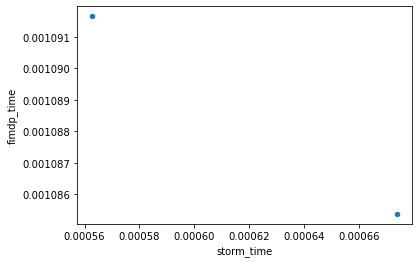

In [25]:
df.set_index(["size","capacity"]).plot("storm_time", "fimdp_time", kind="scatter")

In [26]:
df.set_index(["size","capacity"]).round(1)

cmdp_size  mdp_size  fimdp_time  storm_time
size capacity                                             
4.0  4.0            16.0      73.0         0.0         0.0
     8.0            16.0     129.0         0.0         0.0

<AxesSubplot:xlabel='storm_time', ylabel='fimdp_time'>

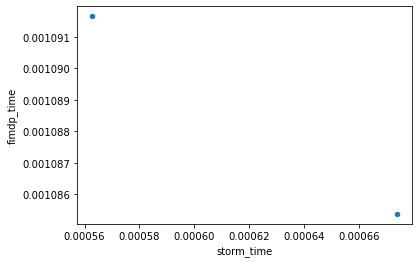

In [27]:
df.plot("storm_time", "fimdp_time", kind="scatter")